# Supervised Models

In [1]:
%reload_ext autoreload
%autoreload 2
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from scipy.stats import randint
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.naive_bayes import MultinomialNB
import helper_functions as hlf
import itertools

%matplotlib inline

### Load the additional features and cleaned reviews datasets

In [7]:
# load engineered features csv
df_engineered = pd.read_csv('df_engineered.csv')

# scaling features
cols = df_engineered.columns
scaler = StandardScaler()
scaler.fit(df_engineered)
scaled_features = scaler.transform(df_engineered)

df_engineered = pd.DataFrame(scaled_features, columns=cols, index=df_engineered.index)
eng_corr_map = df_engineered.corr()

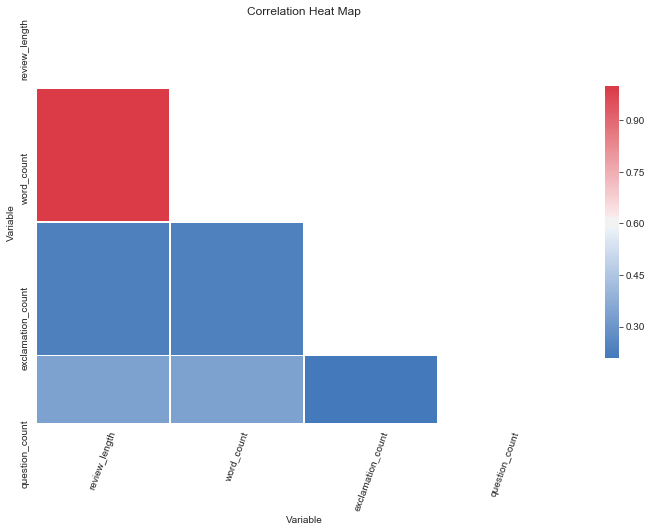

In [16]:
# check for autocorrelation between the engineered features
hlf.CorrMtx(eng_corr_map, dropDuplicates=True)

In [17]:
# drop the word count feature - high correlation with review length
df_engineered.drop('word_count', axis=1, inplace=True)

# load reviews csv
reviews_df = pd.read_csv('final_df.csv')

In [18]:
# create a datataframe for the reviews, engineered features and labels
reviews_lables_df = pd.concat([reviews_df['reviews'], df_engineered, reviews_df['overall']], axis=1)
reviews_lables_df.dropna(inplace=True)
reviews_lables_df.reset_index(drop=True, inplace=True)

In [19]:
# train test split - default 25% of reviews allocated for testing
features_df = reviews_lables_df.drop('overall', axis=1)            
target_df = reviews_lables_df.copy(deep=True)['overall']

x_train, x_test, y_train, y_test = train_test_split(features_df, target_df, random_state=123)

In [20]:
# create train/test dataframes with just the engineered features
train_engineered = x_train.drop('reviews', axis=1)
test_engineered = x_test.drop('reviews', axis=1)

### Vectorize

In [8]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.5, max_features=50000,
                                   min_df=15, token_pattern = '(?ui)\\b\\w*[a-z]+\\w*\\b', 
                                   analyzer='word')
# vectorize the train set
tfidf_train = tfidf_vectorizer.fit_transform(x_train['reviews'])

# vectorize the test set
tfidf_test = tfidf_vectorizer.transform(x_test['reviews'])

### LSA

In [9]:
# reduce dimnsionality
svd = TruncatedSVD(n_components=100)

# transoform train set
train_LSA = svd.fit_transform(tfidf_train)
train_LSA_df = pd.DataFrame(train_LSA)

# transform test set
test_LSA = svd.transform(tfidf_test)
test_LSA_df = pd.DataFrame(test_LSA)

In [24]:
# gain insight what the principal components are made of
feature_names = tfidf_vectorizer.get_feature_names()
word_svd_vector_df = pd.DataFrame(svd.components_, index=range(1, 101), columns=feature_names)
print(f'Explained Variance Ratio: {svd.explained_variance_ratio_.sum()}')
word_svd_vector_df.head()

Explained Variance Ratio: 0.1884130791452843


,000mah,00am,016g,032g,055xprob,064g,0a,0gb,0ghz,0i,...,zs8,zuiko,zumo,zune,zunes,zvox,zx100,zx3,zx5,zyxel
1,0.000133,0.000042,0.000065,0.000071,0.000046,0.000040,0.000127,0.000079,0.000193,0.000043,...,0.000112,0.000159,0.000166,0.004556,0.000174,0.000314,0.000078,0.000153,0.000145,0.000660
2,0.000057,-0.000020,0.000043,-0.000033,0.000133,-0.000055,-0.000110,-0.000141,-0.000204,-0.000058,...,0.000505,0.000758,-0.000062,-0.001918,-0.000127,-0.000487,-0.000052,0.000410,0.000337,-0.001094
3,-0.000134,-0.000022,-0.000215,-0.000216,-0.000007,-0.000148,-0.000172,-0.000246,-0.000217,-0.000081,...,-0.000149,-0.000128,-0.000090,0.003843,0.000106,0.000877,0.000321,-0.000227,-0.000145,-0.000789
4,-0.000042,-0.000025,-0.000108,-0.000070,-0.000025,0.000003,-0.000019,0.000015,0.000016,0.000015,...,-0.000252,-0.000441,-0.000006,0.000698,-0.000041,-0.000417,-0.000073,-0.000386,-0.000319,-0.000355
5,0.000574,0.000022,-0.000186,-0.000174,-0.000059,-0.000112,0.000172,-0.000182,-0.000077,-0.000016,...,-0.000166,-0.000514,0.000129,0.001226,0.000047,-0.000183,0.000023,0.000060,-0.000172,0.000068


In [11]:
# merge the vectorized reviews with the engineered features
train_engineered.reset_index(drop=True, inplace=True)
test_engineered.reset_index(drop=True, inplace=True)

train_svd_df = pd.merge(train_LSA_df, train_engineered, left_index=True, right_index=True)
test_svd_df = pd.merge(test_LSA_df, test_engineered, left_index=True, right_index=True)

# Modeling

## Dummy classifier

In [12]:
dummy = DummyClassifier()
dummy_LSA = dummy.fit(train_svd_df, y_train)
dummy_pred = dummy_LSA.predict(test_svd_df)

# check how badly the model preforms
dummy_metrics = hlf.print_metrics(y_test, dummy_pred, print_score=True)
classes = list(range(1, 6))

Recall: 20.07
Accuracy: 20.07
F1 Score: 20.07


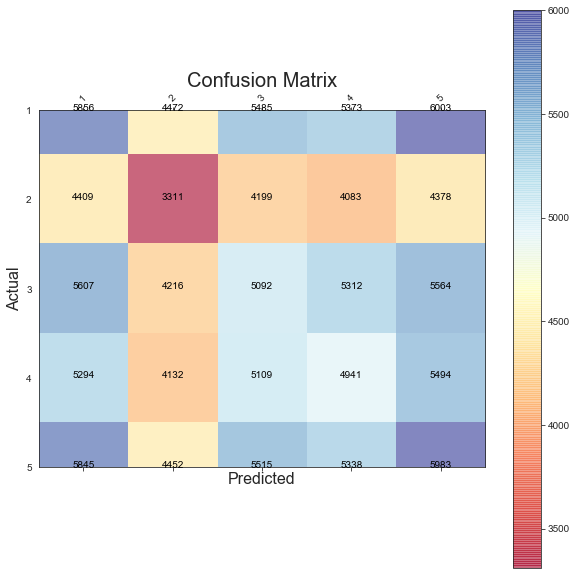

In [14]:
hlf.plot_confusion_matrix(y_test, dummy_pred, classes)

## Decision Tree

In [15]:
DT = DecisionTreeClassifier()
DT_model = DT.fit(train_svd_df, y_train)
DT_pred = DT_model.predict(test_svd_df)

# check how badly the model preforms
DT_metrics = hlf.print_metrics(y_test, DT_pred, print_score=True)

Recall: 28.44
Accuracy: 28.44
F1 Score: 28.44


### Update - Unfortunately random/grid search was unable to complete due to limited computational power

## Naive Bayes

In [16]:
# due to lack of computing power, max features was reduced to 2500 before running naive bayes
tfidf_naive_vectorizer = TfidfVectorizer(max_df=0.5, max_features=2500,
                                   min_df=15, token_pattern = '(?ui)\\b\\w*[a-z]+\\w*\\b', 
                                   analyzer='word')

# vectorize the train set
tfidf_naiv_train = tfidf_naive_vectorizer.fit_transform(x_train['reviews'])
naive_train_df = pd.DataFrame(tfidf_naiv_train.toarray(), columns=tfidf_naive_vectorizer.get_feature_names())

# vectorize the test set
tfidf_naive_test = tfidf_naive_vectorizer.transform(x_test['reviews'])
naive_test_df = pd.DataFrame(tfidf_naive_test.toarray(), columns=tfidf_naive_vectorizer.get_feature_names())

In [17]:
# NB with tfidf
NB = MultinomialNB()
NB_model = NB.fit(naive_train_df, y_train)
NB_pred = NB.predict(naive_test_df)

# check how badly the model preforms
NB_metrics = hlf.print_metrics(y_test, NB_pred, print_score=True)

Recall: 46.52
Accuracy: 46.52
F1 Score: 46.52


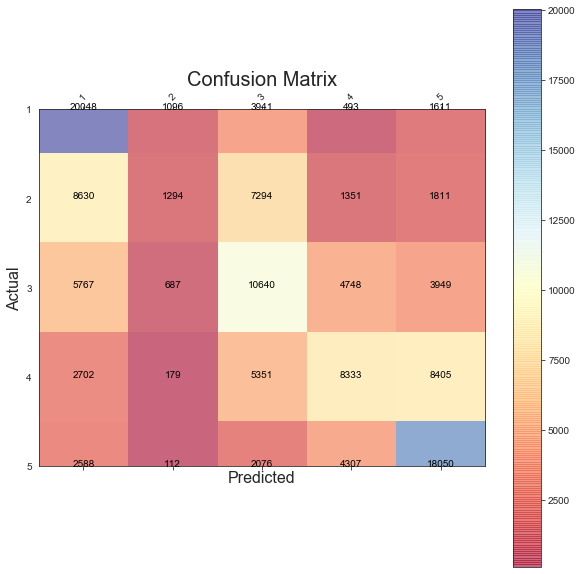

In [18]:
hlf.plot_confusion_matrix(y_test, NB_pred, classes)

## Random Forest

In [19]:
# get a baseline how random forest performs
RForest = RandomForestClassifier(random_state=123, n_jobs=-1)
RForest.fit(train_svd_df, y_train)

# predcit
RForest_pred = RForest.predict(test_svd_df)

# test how badly the model performs 
RForest_metrics = hlf.print_metrics(y_test, RForest_pred, print_score=True)

D:\Programs\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Recall: 32.87
Accuracy: 32.87
F1 Score: 32.87


### Update - Unfortunately random/grid search was unable to complete due to limited computational power

## AdaBoost

In [20]:
# get a baseline on how ada boost performs
ADA = AdaBoostClassifier(random_state=123)
ADA.fit(train_svd_df, y_train)

# predict
ADA_pred = ADA.predict(test_svd_df)

# test how badly model performs 
hlf.print_metrics(y_test, ADA_pred, print_score=True)

Recall: 38.52
Accuracy: 38.52
F1 Score: 38.52


## XGBoost

Recall: 40.26
Accuracy: 40.26
F1 Score: 40.26


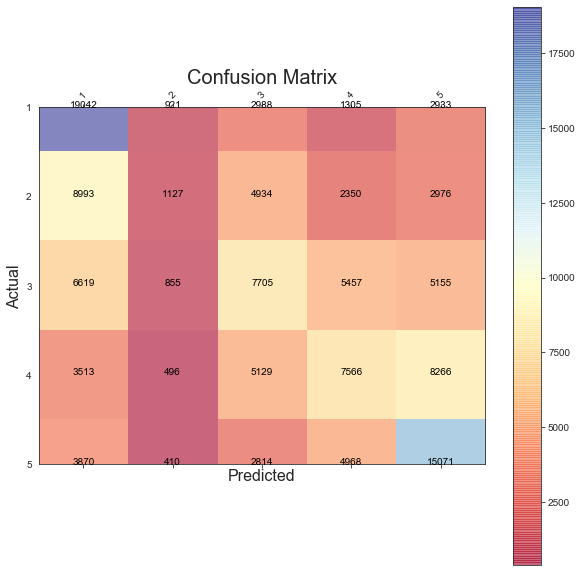

In [21]:
import xgboost as xgb

# get a baseline on how xgboost performs
XGBoost = xgb.XGBClassifier(random_state=123)
XGBoost.fit(train_svd_df, y_train)

# predict
XGBoost_pred = XGBoost.predict(test_svd_df)

# test how badly the model performs 
hlf.print_metrics(y_test, XGBoost_pred, print_score=True)
hlf.plot_confusion_matrix(y_test, XGBoost_pred, classes)

## Logistic Regression

D:\Programs\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Programs\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Recall: 43.81
Accuracy: 43.81
F1 Score: 43.81


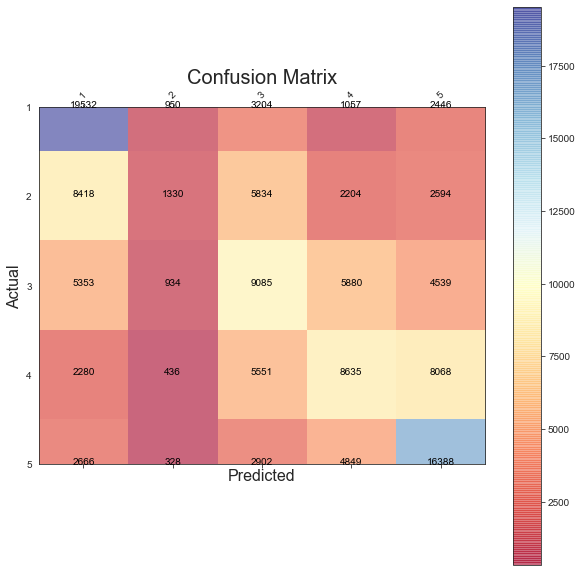

In [22]:
# check the baseline how logistic regression performs
LogReg = LogisticRegression(fit_intercept = False, C = 1e12)
LogReg.fit(train_svd_df, y_train)

# predict
LogReg_pred = LogReg.predict(test_svd_df)

# test how badly the model performs 
hlf.print_metrics(y_test, LogReg_pred, print_score=True)
hlf.plot_confusion_matrix(y_test, LogReg_pred, classes)